# Fishing Effort Iceland

In [1]:
from math import radians, cos, sin, asin, sqrt
import matplotlib
%matplotlib inline
from matplotlib import colors,colorbar
from matplotlib.patches import PathPatch,Polygon
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from numpy import asarray, concatenate, ones
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.ops import transform
import bq  
import csv 
import fiona
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import time

client = bq.Client.Get()

/Users/David/Desktop/Jobs/GlobalFishingWatch/github/vessel-maps/utilities/pipa_paper/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [18]:
# create a bounding box:
max_lat = 69
min_lat = 60
min_lon = -30
max_lon = -6


one_over_cellsize = 20
cellsize = .05

In [7]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [16]:
def makeMap(grid,fig_title,fig_min_value,fig_max_value):

    tm = 255
    thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
              ['#62000C',255,255]]
    cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
          'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
          'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

    mycmap_redder = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    
    fig = plt.figure(figsize=(12, 8)) 
    
    firstlat = max_lat
    lastlat =  min_lat
    firstlon = min_lon
    lastlon = max_lon
    scale = cellsize

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    extra = 0
    m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
              llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

    m.drawmapboundary()#fill_color='#111111')
#     m.drawcoastlines(linewidth=.2)
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

    x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = fig_max_value # grid.max()
    minimum = fig_min_value #1

    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)

    m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap("viridis"))

    t = fig_title
    plt.title(t, color = "#000000", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=7)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap("viridis"))

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
    cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
    cb.set_label('Fishing Hours per Quarter Degree Square',labelpad=-40, y=0.45, color = "#000000")
    plt.savefig(fig_title+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
    plt.show()

Waiting on bqjob_r2aca1ce9deef1b6e_00000158083fd643_7 ... (23s) Current status: DONE   
Query time: 30.0974738598 seconds.


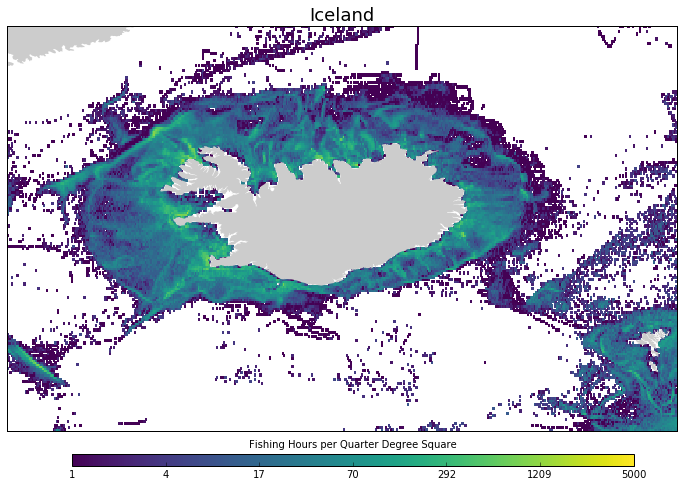

In [19]:
# Map Fishing in High Seas
q = '''
SELECT
  INTEGER(floor(lat*'''+str(one_over_cellsize)+''')) lat_bin,
  INTEGER(floor(lon*'''+str(one_over_cellsize)+''')) lon_bin,
  SUM(hours) hours
FROM
  (select lat, lon, hours, measure_new_score, seg_id, mmsi from
  TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
WHERE
       lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+'''
  AND measure_new_score >=.5) where 
       seg_id NOT IN ( // eliminate clearly bad segments
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_715.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
  
GROUP BY
  lat_bin,
  lon_bin
'''
# print q
fishing_grid = Query(q)

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])
    
makeMap(grid,"Iceland",1,5000.2)

Waiting on bqjob_r7b08dde559787c1f_0000015808447445_8 ... (23s) Current status: DONE   
Query time: 27.9430758953 seconds.


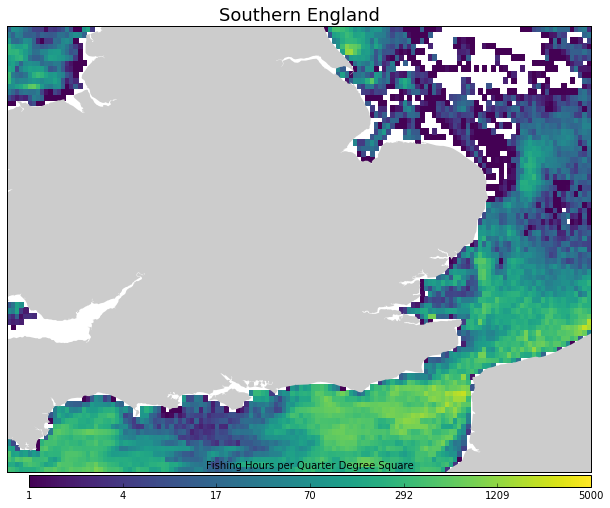

In [20]:
# create a bounding box:
max_lat = 54
min_lat = 50
min_lon = -4
max_lon = 3


one_over_cellsize = 20
cellsize = .05


# Map Fishing in High Seas
q = '''
SELECT
  INTEGER(floor(lat*'''+str(one_over_cellsize)+''')) lat_bin,
  INTEGER(floor(lon*'''+str(one_over_cellsize)+''')) lon_bin,
  SUM(hours) hours
FROM
  (select lat, lon, hours, measure_new_score, seg_id, mmsi from
  TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
WHERE
       lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+'''
  AND measure_new_score >=.5) where 
       seg_id NOT IN ( // eliminate clearly bad segments
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_715.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
  
GROUP BY
  lat_bin,
  lon_bin
'''
# print q
fishing_grid = Query(q)

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])
    
makeMap(grid,"Southern England",1,5000.2)